In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import shelve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import h5py
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_x.h5"
h5_img = h5py.File(path, "r")
ds_img = h5_img['x']

path = "/content/gdrive/MyDrive/pcam/camelyonpatch_level_2_split_train_y.h5"
h5_lbl = h5py.File(path, "r")
ds_lbl = h5_lbl['y']

Necessary swaps for Dataset class:

- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.

- The images are resized to resize_size=[256] (this is dependent on model, ViT_L_16 prefs 242) using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].

- Finally the values are first rescaled to [0.0, 1.0]

- Then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [47]:
class pcamDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    self.length = len(labels)

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    np_img = np.array(self.images[idx]) # Get item as np array
    np_img = np_img.astype(np.uint8) # change dtype from u1 to uint8
    pil_img = PIL.Image.fromarray(np_img) # use PIL for transforms since Resize expects PIL.Image
    preprocess = transforms.Compose([ # Compose used for future edits
            transforms.Resize(256, interpolation=InterpolationMode.BILINEAR), # note the interpolation
            transforms.CenterCrop(224),
            transforms.ToTensor(), # convert from PIL.Image to torch.Tensor, automatically rearranges dimensions from HWC to CHW
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # standard normalization for ViT
        ])
    tensor_img = preprocess(pil_img)

    label = self.labels[idx]
    label_tensor = torch.tensor(label)

    sample = {'image': tensor_img, 'label': label_tensor.long()}
    return sample

In [27]:
# Make a ViT model

model = torchvision.models.vit_b_32(weights="DEFAULT")

In [32]:
model_opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
checkpoint = torch.load("/content/gdrive/MyDrive/checkpoints/004_ViT.ckpt")
model.load_state_dict(checkpoint['model_state_dict'])
model_opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [48]:
# Creation and moving to GPU

dset = pcamDataset(ds_img, ds_lbl)
trainloader = DataLoader(dset, batch_size=96, shuffle=True, num_workers=2, pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("done")

done


In [49]:
trainloader.__len__()

2731

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [50]:
loss_mem = []
model.train()
for i, data in enumerate(trainloader):
  # 29 min train for rn18; lr = 0.01
  # 49min for rn50; lr = 0.01
  # 1hr train for ViT fixed; lr = 0.01
  # xhr train for ViT quartered; lr = 0.01
  image = data['image'].to(device)
  label = data['label'].view(-1).to(device)
  optimizer.zero_grad()
  output = model(image)
  loss = criterion(output, label)
  loss.backward()
  optimizer.step()
  loss_mem.append(loss.data.item())

  if i == (trainloader.__len__() // 2):
    epoch = 6 # Change each training instance!
    path = F"/content/gdrive/My Drive/checkpoints/%03d_ViT.ckpt" % epoch
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path)
    break

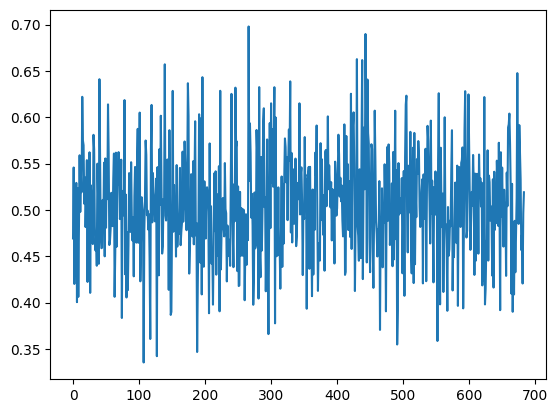

In [45]:
plt.plot(loss_mem)

In [37]:
epoch = 3.5 # Change each training instance!
path = F"/content/gdrive/My Drive/checkpoints/%03d_ViT.ckpt" % epoch
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)

In [38]:
path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_x.h5"
h5_img_test = h5py.File(path, "r")
ds_img_test = h5_img_test['x']

path = "/content/gdrive/MyDrive/pcam/test/camelyonpatch_level_2_split_test_y.h5"
h5_lbl_test = h5py.File(path, "r")
ds_lbl_test = h5_lbl_test['y']

test_dset = pcamDataset(ds_img_test, ds_lbl_test)
test_trainloader = DataLoader(test_dset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
score = []
for i, data in enumerate(test_trainloader):
  image = data['image'].to(device)
  label = data['label'].view(-1).to(device)
  output = model(image)
  output_numpy = output.cpu().data.numpy()
  output_argmax = np.argmax(output_numpy, axis=1)
  labels_numpy = label.cpu().data.numpy()
  score = np.concatenate((score, (labels_numpy==output_argmax).astype(int)), axis=0)

meanAcc = sum(score)/len(score)
print(meanAcc)

0.7136644541084917
